<a href="https://colab.research.google.com/github/knxghtly/python-tensorflow-MLDL-Study/blob/main/%5B9%5D%EC%88%9C%ED%99%98%EC%8B%A0%EA%B2%BD%EB%A7%9D(Reccurent_Neural_Network%2C_RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

순환신경망
*   입력층과 순환층은 완전연결
*   은닉 상태(결과=h)가 다음 타임스텝의 샘플을 처리할 때 **재사용**됨
*   이 때, 순환층의 은닉 상태는 다시 순환층으로 완전연결됨
*   RNN 유닛의 활성화함수: tanh

###순환신경망의 입력

한 단어를 3개의 벡터로 처리한다고 할 때,

*   (I) (am) (a) (boy) => (
  1(샘플),
  4(단어=토큰=시퀀스길이=타임스텝),
  3(처리단위))




#데이터 준비

In [ ]:
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# data 로드 & 샘플 개수(batch_size)=15000, voca=400 조정
(train_input, train_target), (test_input, test_target) = keras.datasets.imdb.load_data(num_words=400)
for var in ["train_input", "train_target", "test_input", "test_target"]:
    globals()[var] = globals()[var][:10000]
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

# 시퀀스패딩 후 one-hot 인코딩
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_oh = keras.utils.to_categorical(pad_sequences(train_input, maxlen=100))
val_oh = keras.utils.to_categorical(pad_sequences(val_input, maxlen=100))
for var in ["train_input", "train_target", "val_input", "val_target", "test_input", "test_target"]:
    print(var+".shape:\t", globals()[var].shape)
for var in ["train_oh", "val_oh"]:
    print(var+".shape:\t", globals()[var].shape)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
train_input.shape:	 (8000,)
train_target.shape:	 (8000,)
val_input.shape:	 (2000,)
val_target.shape:	 (2000,)
test_input.shape:	 (10000,)
test_target.shape:	 (10000,)
train_oh.shape:	 (8000, 100, 400)
val_oh.shape:	 (2000, 100, 400)


##데이터확인

[160 439 148 ... 120 300 190]


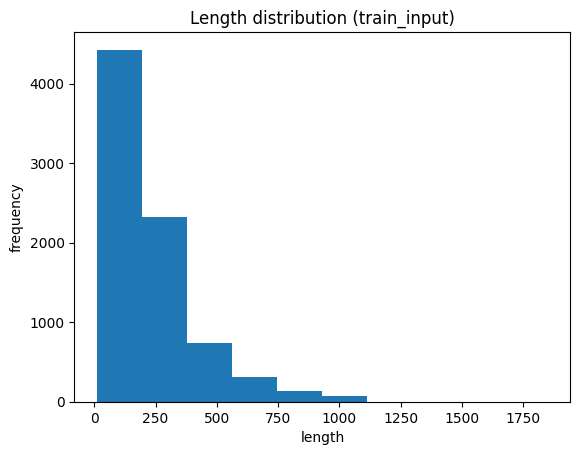

In [ ]:
# train_input: numpy.array[ list(), list(), ... ]
lengths = np.array([len(x) for x in train_input])
print(lengths)
plt.hist(lengths)
plt.title("Length distribution (train_input)")
plt.xlabel("length")
plt.ylabel("frequency")
plt.show()

In [ ]:
print(pad_sequences(train_input, maxlen=100)[0][-18:])
print(np.array(train_input[0][-18:]))

[  9  35 321 167  10  10  13 168   2   8 111  53 102  39  90  11   4   2]
[  9  35 321 167  10  10  13 168   2   8 111  53 102  39  90  11   4   2]


#모델 구성(one-hot)

 - RNN 계열 층은 기본적으로 마지막 타임스텝의 출력만 반환
 `(batch_size, 뉴런개수)`
 - 따라서 RNN층 다음에는 Flatten층 놓을 필요 없음
 - `return_sequences=True`로 모든 타임스텝 출력가능(순환층 2개 이상)

In [ ]:
keras.backend.clear_session()

In [ ]:
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 400)))
model.add(keras.layers.Dense(1, activation="sigmoid"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


###compile, fit

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss="binary_crossentropy",
              metrics=["accuracy"])
# callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-simplernn-model.keras")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 8)                   │           3,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,281 (12.82 KB)

 Trainable params: 3,281 (12.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history1 = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    verbose=0,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

결과 확인

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


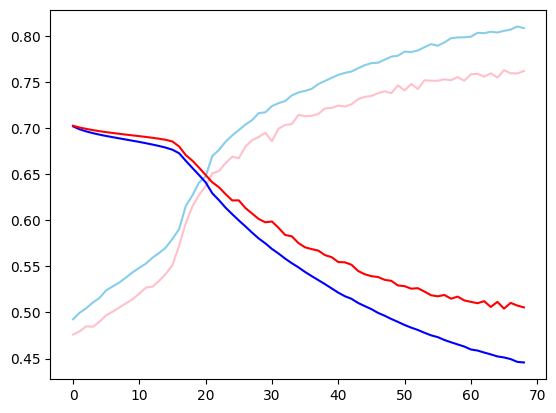

[0.452 0.451 0.449 0.446 0.446]


In [ ]:
print(history1.history.keys())
plt.plot(history1.history["accuracy"], color="skyblue")
plt.plot(history1.history["val_accuracy"], color="pink")
plt.plot(history1.history["loss"], color="b")
plt.plot(history1.history["val_loss"], color="r")
plt.show()
print(np.round(history1.history["loss"][-5:], decimals=3))

#모델 구성(embedding)

- 원핫 인코딩을 하게 되면 메모리 낭비가 심함
- 단어를 여러 벡터로 나타내서 메모리도 줄이고, 유사도도 표현 가능

```
# IN RNN, GRU and LSTM, input is of shape (N,T,D),
# N is the number of samples,
# T is length of time sequence and D is the number of features.
```

In [ ]:
keras.backend.clear_session()

In [ ]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(input_dim=400, output_dim=16, input_shape=(100,)))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation="sigmoid"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


(8000,)
(8000, 100)
(8000, 100, 400)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 16)             │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 8)                   │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,609 (25.82 KB)

 Trainable params: 6,609 (25.82 KB)

 Non-trainable params: 0 (0.00 B)

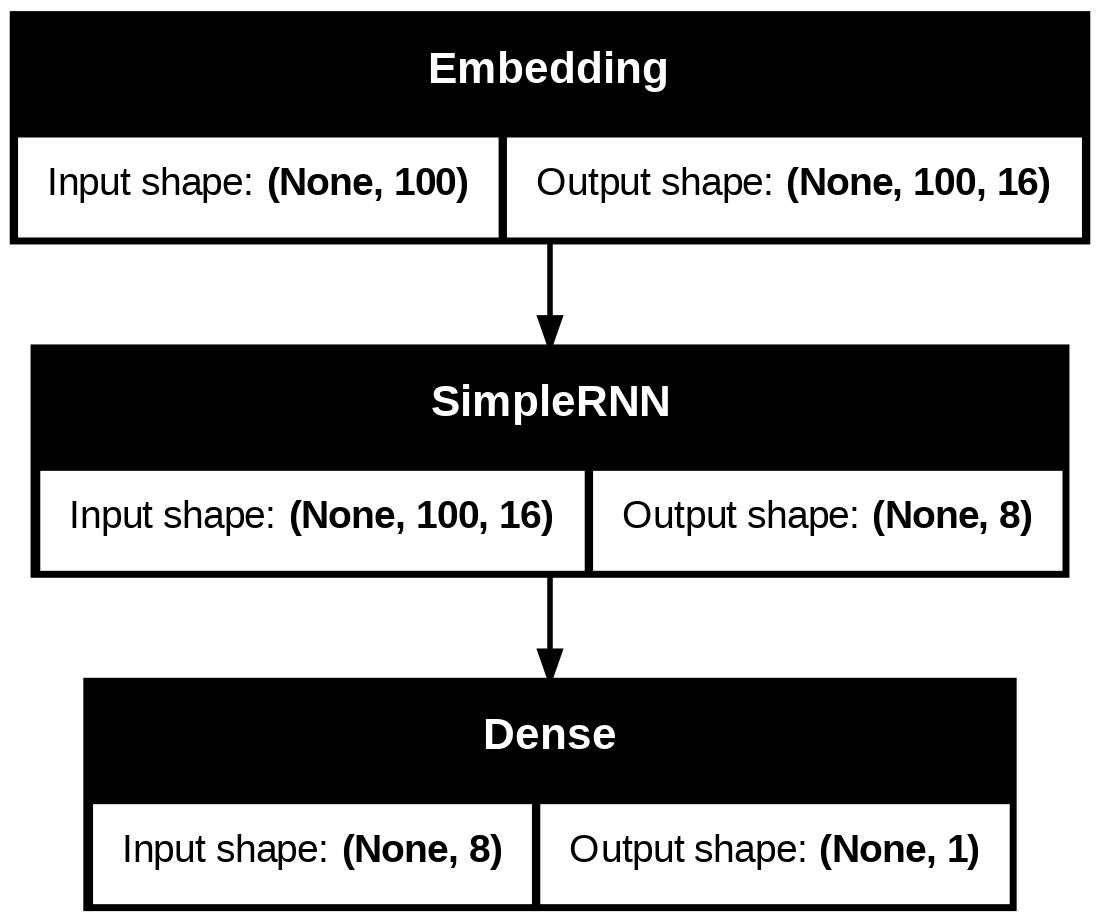

In [ ]:
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)
print(train_input.shape)
print(train_seq.shape)
print(train_oh.shape)
model2.summary()
keras.utils.plot_model(model2, show_shapes=True)

###compile, fit

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss="binary_crossentropy",
              metrics=["accuracy"])
# callbacks
checkpoint_cb2 = keras.callbacks.ModelCheckpoint("best-simplernn-model.keras")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3)

In [ ]:
history2 = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                    verbose=0,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb2, early_stopping_cb])

결과 확인

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


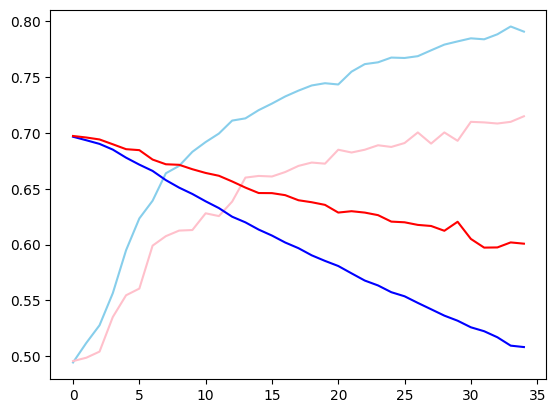

[0.526 0.522 0.517 0.509 0.508]


In [ ]:
print(history2.history.keys())
plt.plot(history2.history["accuracy"], color="skyblue")
plt.plot(history2.history["val_accuracy"], color="pink")
plt.plot(history2.history["loss"], color="b")
plt.plot(history2.history["val_loss"], color="r")
plt.show()
print(np.round(history2.history["loss"][-5:], decimals=3))